In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetV2M
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
# Define input image size
input_size = (224, 224)

# Load pre-trained EfficientNetV2M model
base_model = EfficientNetV2M(input_shape=(input_size[0], input_size[1], 3), include_top=False, weights='imagenet')

In [ ]:
# Add global average pooling and dense output layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x) # Add additional dense layer for feature extraction
predictions = Dense(2, activation='softmax')(x) # Output layer with 5 classes for face shapes

In [ ]:
# Create the model
model = Model(inputs=base_model.input, outputs=predictions)

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Define a callback to save the model with the highest validation accuracy
checkpoint = ModelCheckpoint('face_shape_model.h5', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)

In [ ]:
# Defining model file name
filePath ='EfficientNetV2-M'+ '_BestModel.h5'

# Defining model checkpoint for saving best model
bestModelCheckpoint = ModelCheckpoint(filePath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)

# Defining decaying learning rate callback
decayLR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=3)

# Defining early stopping callback
earlystopCheckpoint = EarlyStopping(monitor="val_loss", min_delta=0, patience=9, verbose=1)

# Preparing list of all callbacks
callbacksList = [bestModelCheckpoint, decayLR, earlystopCheckpoint]

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255, # Normalize pixel values
    rotation_range=20, # Rotate images randomly within a range of 20 degrees
    width_shift_range=0.1, # Shift images horizontally by a maximum of 10% of the image width
    height_shift_range=0.1, # Shift images vertically by a maximum of 10% of the image height
    horizontal_flip=True, # Flip images horizontally randomly
    vertical_flip=False, # Do not flip images vertically
)

valid_datagen = ImageDataGenerator(
    rescale=1./255, # Normalize pixel values
)


In [ ]:
train_generator = train_datagen.flow_from_directory(
    "/content/drive/MyDrive/DataSet/GenderDetectionFace/train", # Path to training data
    target_size=input_size,
    batch_size=32,
    class_mode='categorical'# Use 80% of data for training
)

validation_generator = valid_datagen.flow_from_directory(
    "/content/drive/MyDrive/DataSet/GenderDetectionFace/valid", # Path to training data
    target_size=input_size,
    batch_size=32,
    class_mode='categorical'# Use 20% of data for validation
)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# Train the model with the callback
model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=100, # Number of training epochs
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    callbacks=[callbacksList] # Add the callback to the training process
)

Epoch 1/100
50/50 [==============================] - ETA: 0s - loss: 0.3162 - accuracy: 0.8775
Epoch 1: val_loss improved from inf to 0.88180, saving model to EfficientNetV2-M_BestModel.h5
50/50 [==============================] - 699s 11s/step - loss: 0.3162 - accuracy: 0.8775 - val_loss: 0.8818 - val_accuracy: 0.4969 - lr: 0.0010
Epoch 2/100
50/50 [==============================] - ETA: 0s - loss: 0.1164 - accuracy: 0.9531
Epoch 2: val_loss improved from 0.88180 to 0.70349, saving model to EfficientNetV2-M_BestModel.h5
50/50 [==============================] - 52s 1s/step - loss: 0.1164 - accuracy: 0.9531 - val_loss: 0.7035 - val_accuracy: 0.5344 - lr: 0.0010
Epoch 3/100
50/50 [==============================] - ETA: 0s - loss: 0.0913 - accuracy: 0.9694
Epoch 3: val_loss did not improve from 0.70349
50/50 [==============================] - 48s 943ms/step - loss: 0.0913 - accuracy: 0.9694 - val_loss: 0.9670 - val_accuracy: 0.4969 - lr: 0.0010
Epoch 4/100
50/50 [==========================

In [ ]:
from tensorflow.keras.models import load_model

modelMy = load_model('/content/drive/MyDrive/Dataset/gender_classification_model_EfficientNetV2M_Version_01.h5')

In [ ]:
# Data augmentation for testing
test_datagen = ImageDataGenerator(
    rescale=1./255 # Normalize pixel values
)

In [ ]:
test_generator = test_datagen.flow_from_directory(
    "/content/drive/MyDrive/DataSet/GenderDetectionFace/test", # Path to test data
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False # Do not shuffle the test data
)

Found 340 images belonging to 2 classes.


In [ ]:
scores = modelMy.evaluate(test_generator, steps=test_generator.samples // test_generator.batch_size + 1)


11/11 [==============================] - 104s 9s/step - loss: 0.0614 - accuracy: 0.9765


11/11 [==============================] - 10s 549ms/step


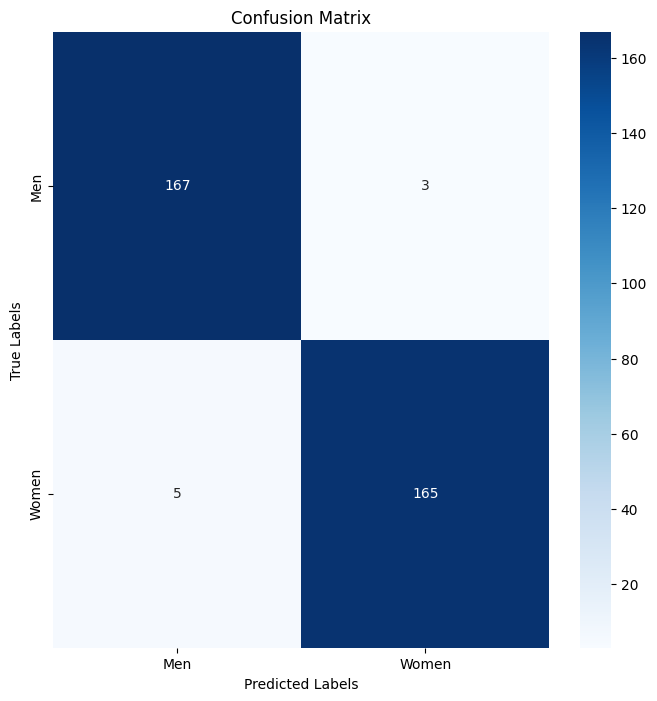

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Generate predictions for the test set
y_pred = modelMy.predict(test_generator, steps=test_generator.samples // test_generator.batch_size + 1)
y_pred_classes = np.argmax(y_pred, axis=1)

# Get the true labels for the test set
y_true = test_generator.classes

# Compute the confusion matrix
conf_mat = confusion_matrix(y_true, y_pred_classes)

# Plot the confusion matrix as a heatmap
fig, ax = plt.subplots(figsize=(8, 8))
sns.heatmap(conf_mat, annot=True, cmap='Blues', fmt='d', ax=ax)
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(["Men", "Women"])
ax.yaxis.set_ticklabels(["Men", "Women"])
plt.show()

In [ ]:
from sklearn.metrics import classification_report
from tensorflow.keras.utils import to_categorical

# Define the labels and their corresponding indices
labels = ["Men", "Women"]
label_map = {label: i for i, label in enumerate(labels)}

y_pred = modelMy.predict(test_generator)
y_true = to_categorical(test_generator.labels, num_classes=len(labels))

# Convert the predicted and true labels to class indices
y_pred_class = y_pred.argmax(axis=1)
y_true_class = y_true.argmax(axis=1)

# Generate a classification report
report = classification_report(y_true_class, y_pred_class, target_names=labels)

# Print the classification report
print(report)

11/11 [==============================] - 3s 236ms/step
              precision    recall  f1-score   support

         Men       0.97      0.98      0.98       170
       Women       0.98      0.97      0.98       170

    accuracy                           0.98       340
   macro avg       0.98      0.98      0.98       340
weighted avg       0.98      0.98      0.98       340



11/11 [==============================] - 3s 232ms/step


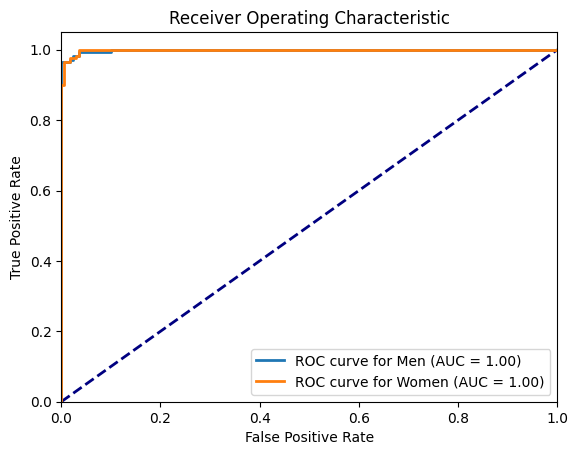

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

labels = ["Men", "Women"]

y_pred = modelMy.predict(test_generator)
y_true = test_generator.classes

# Get the predicted class labels
y_pred_class = y_pred.argmax(axis=1)

# Calculate the fpr and tpr for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(labels)):
    fpr[i], tpr[i], _ = roc_curve(y_true == i, y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plotting the ROC curve
plt.figure()
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
for i, label in enumerate(labels):
    plt.plot(fpr[i], tpr[i], lw=2, label='ROC curve for %s (AUC = %0.2f)' % (label, roc_auc[i]))
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [ ]:
modelMy.save('/content/drive/MyDrive/Dataset/gender_classification_model_EfficientNetV2M_Version_01.h5')